# Notebook for analysing all VR trials of one experimental group; 2-object forest

## For anaysis of *HC conditioning experiments*

### Assumes use of FlyOver version 9.7 or higher (closed-loop optogenetic stimulation possible)
### Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [254]:
import numpy as np
import pandas as pd 
    
from os import mkdir, walk, getcwd
from os.path import sep, exists
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec, rcParams
import seaborn as sns

import imageio

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleTwoObjVROptogenTrialAnalysis

from plottingUtilities.basicPlotting import makeNestedPlotDirectory, myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import plotWalkingVelocityDistr
from plottingUtilities.plotsWithDataframe import oneDimResidencyWithVar_2LM_df

from trajectoryAnalysis.trajectoryDerivedParams import relationToObject
from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec

from plottingUtilities.objectPreferencePlots import countvisits, diffCorrPlot, prettyBoxPlot, simpleBoxPlot,\
            landmarksInSquareTile


# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [255]:
expDirs=expDirs[:]
print(expDirs)

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25']


In [272]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
from operator import itemgetter
my_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 24]#[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24]
expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = '_min5Visits'#'_top10'  # chose small string, to specify dataset (e.g. top5 flies)

In [273]:
%matplotlib inline 
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

### Compose mutli-fly data into dataframe

In [274]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [275]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [276]:
#FODataFiles[0].split('_')

In [277]:
genotype = FODataFiles[0].split('_')[6]#5
condition = FODataFiles[0].split('_')[7]#6
print(genotype)
print(condition)

10xChrR-HC-Ret
10bl


In [278]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','condition','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

nTrialsPr = 0
nTrialsTr = 0
nTrialsPo = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[8]#7
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleTwoObjVROptogenTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
            nTrialsTr += 1
        elif 'pre' in fileToAnalyse:
            trialtype = 'pre'
            rZones = 'off'
            nTrialsPr += 1
        else:
            trialtype = 'post'
            rZones = 'off'
            nTrialsPo += 1
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'condition', condition)
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/controlShifted/male/rawData/m01/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_6-7d_9h_10xChrR-HC-Ret_10bl_m01_post_out_170202203959.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_6-7d_9h_10xChrR-HC-Ret_10bl_m01_pre_out_170202194613.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_6-7d_9h_10xChrR-HC-Ret_10bl_m01_train_out_170202201815.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/controlShifted/male/rawData/m02/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_7-8d_6h_10xChrR-HC-Ret_10bl_m02_post_out_170203163015.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGr

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/controlShifted/male/rawData/m16/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_6h_10xChrR-HC-Ret_10bl_m16_post_out_170301191203.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_6h_10xChrR-HC-Ret_10bl_m16_pre_out_170301183951.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_6h_10xChrR-HC-Ret_10bl_m16_train_out_170301185017.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/controlShifted/male/rawData/m17/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_7h_10xChrR-HC-Ret_10bl_m17_post_out_170301195521.tx

In [279]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df 

flyID trial trialtype reinforcement condition  moving  headingAngle  \
0       m01   1.0      post           off      10bl     1.0     -0.000004   
1       m01   1.0      post           off      10bl     0.0      0.015708   
2       m01   1.0      post           off      10bl     1.0      0.106029   
3       m01   1.0      post           off      10bl     1.0      0.247400   
4       m01   1.0      post           off      10bl     1.0      0.431969   
5       m01   1.0      post           off      10bl     1.0      0.647953   
6       m01   1.0      post           off      10bl     1.0      0.903208   
7       m01   1.0      post           off      10bl     1.0      1.178097   
8       m01   1.0      post           off      10bl     1.0      1.468695   
9       m01   1.0      post           off      10bl     1.0      1.755365   
10      m01   1.0      post           off      10bl     1.0      2.065597   
11      m01   1.0      post           off      10bl     1.0      2.367975   
12      m01   1.0      post           off      10bl     1.0      2.595741   
13      m01   1.0      post           off      10bl     1.0      2.760675   
14      m01   1.0      post           off      10bl     1.0      2.858849   
15      m01   1.0      post           off      10bl     1.0      2.905973   
16      m01   1.0      post           off      10bl     1.0      2.941316   
17      m01   1.0      post           off      10bl     1.0      2.968805   
18      m01   1.0      post           off      10bl     1.0      2.984513   
19      m01   1.0      post           off      10bl     0.0      2.980586   
20      m01   1.0      post           off      10bl     1.0      2.941316   
21      m01   1.0      post           off      10bl     1.0      2.906227   
22      m01   1.0      post           off      10bl     1.0      2.894192   
23      m01   1.0      post           off      10bl     1.0      2.894192   
24      m01   1.0      post           off      10bl     1.0      2.882411   
25      m01   1.0      post           off      10bl     1.0      2.866703   
26      m01   1.0      post           off      10bl     1.0      2.850995   
27      m01   1.0      post           off      10bl     1.0      2.827760   
28      m01   1.0      post           off      10bl     1.0      2.792430   
29      m01   1.0      post           off      10bl     1.0      2.752821   
...     ...   ...       ...           ...       ...     ...           ...   
23970   m25   3.0     train            on      10bl     0.0     -1.162391   
23971   m25   3.0     train            on      10bl     0.0     -1.174172   
23972   m25   3.0     train            on      10bl     0.0     -1.185953   
23973   m25   3.0     train            on      10bl     0.0     -1.217369   
23974   m25   3.0     train            on      10bl     0.0     -1.272347   
23975   m25   3.0     train            on      10bl     0.0     -1.307690   
23976   m25   3.0     train            on      10bl     0.0     -1.299836   
23977   m25   3.0     train            on      10bl     0.0     -1.284128   
23978   m25   3.0     train            on      10bl     0.0     -1.284128   
23979   m25   3.0     train            on      10bl     0.0     -1.299836   
23980   m25   3.0     train            on      10bl     0.0     -1.311617   
23981   m25   3.0     train            on      10bl     0.0     -1.315544   
23982   m25   3.0     train            on      10bl     0.0     -1.307690   
23983   m25   3.0     train            on      10bl     0.0     -1.291982   
23984   m25   3.0     train            on      10bl     0.0     -1.291982   
23985   m25   3.0     train            on      10bl     0.0     -1.291982   
23986   m25   3.0     train            on      10bl     0.0     -1.307690   
23987   m25   3.0     train            on      10bl     0.0     -1.323398   
23988   m25   3.0     train            on      10bl     0.0     -1.335179   
23989   m25   3.0     train            on      10bl     0.0     -1.354814   
23

In [280]:
keyind_x = keylistLong.index('xPos')
keyind_y = keylistLong.index('yPos')
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [281]:
# Two object reinforcement test
rZoneState = ['off','on','off']
visibilityState = ['visible','visible','visible']
groundPlane = ['texture','texture','texture']
trialName = ['pre','train','post']
gridSize = 60.0

fps = 20

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'
LMcols = [coneColor,cyliColor]

LMNames = ['Cone','Cylinder']
numLM = len(LMNames)

In [282]:
visitRad = 15

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

LMcoords = [coneCoords, cyliCoords]

### Compute visit count

In [283]:
visitFreq = np.nan*np.ones((numLM, len(flyIDs), len(trialName)))
visitCount = np.nan*np.ones((numLM, len(flyIDs), len(trialName)))
visitLength = np.zeros((numLM, len(flyIDs), len(trialName)))

for fly in range(len(flyIDs)):
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )
        
        for obj in range(numLM):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
            
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],time,visitRad)
        
            visitFreq[obj,fly,trial] = np.sum(entries)/(time[-1]/60.0)
            visitCount[obj,fly,trial] = np.sum(entries)
            visitLength[obj,fly,trial] = np.sum(visitT)

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in minimum


### Selection of flies for analysis based on landmark visits

In [284]:
#visitCount[0]+visitCount[1]

In [285]:
# minimum amount of visits to any landmark in any trial to be considered in ananlysis
minVisit = 5

notEnoughVistis = np.where(np.sum((visitCount[0][:,:] + visitCount[1][:,:])> minVisit, axis=1)<3)[0]
keepflies = list(np.where(np.sum((visitCount[0][:,:] + visitCount[1][:,:])> minVisit, axis=1)>=3)[0])

# Sort flies to keep according to preference in post
postPref = list(np.argsort(visitCount[0][:,2]-visitCount[1][:,2]))

print('Out of {} measured flies, {} made less than {} landmark visits in at least one of the three trials ({}%).\n').format(numFlies,
     len(notEnoughVistis), minVisit, 100*len(notEnoughVistis)/numFlies)
print('Flies that did not make enough visits:')
print(notEnoughVistis)
print('The remaining {}').format(len(keepflies))
print(keepflies)

Out of 22 measured flies, 0 made less than 5 landmark visits in at least one of the three trials (0%).

Flies that did not make enough visits:
[]
The remaining 22
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [286]:
top10 = list(set(postPref[-13:]).intersection(set(keepflies)))
print('Selected {} flies:').format(len(top10))
print(top10)

Selected 13 flies:
[0, 1, 3, 6, 7, 10, 12, 14, 15, 16, 17, 20, 21]


In [287]:
# minimum amount of visits to ANY landmark in the TRAIN-trial to be considered in ananlysis
minVisitLM = 8

notEnoughVisits = np.where((visitCount[0][:,1] + visitCount[1][:,1]) >= minVisitLM)[0]
keepflies = list(np.where((visitCount[0][:,1] + visitCount[1][:,1]) >= minVisitLM)[0])

print('Flies that made enough visits:')
print(keepflies)
print('n = ' + str(len(keepflies)))

Flies that made enough visits:
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21]
n = 20


### Trajectory plots of all trials

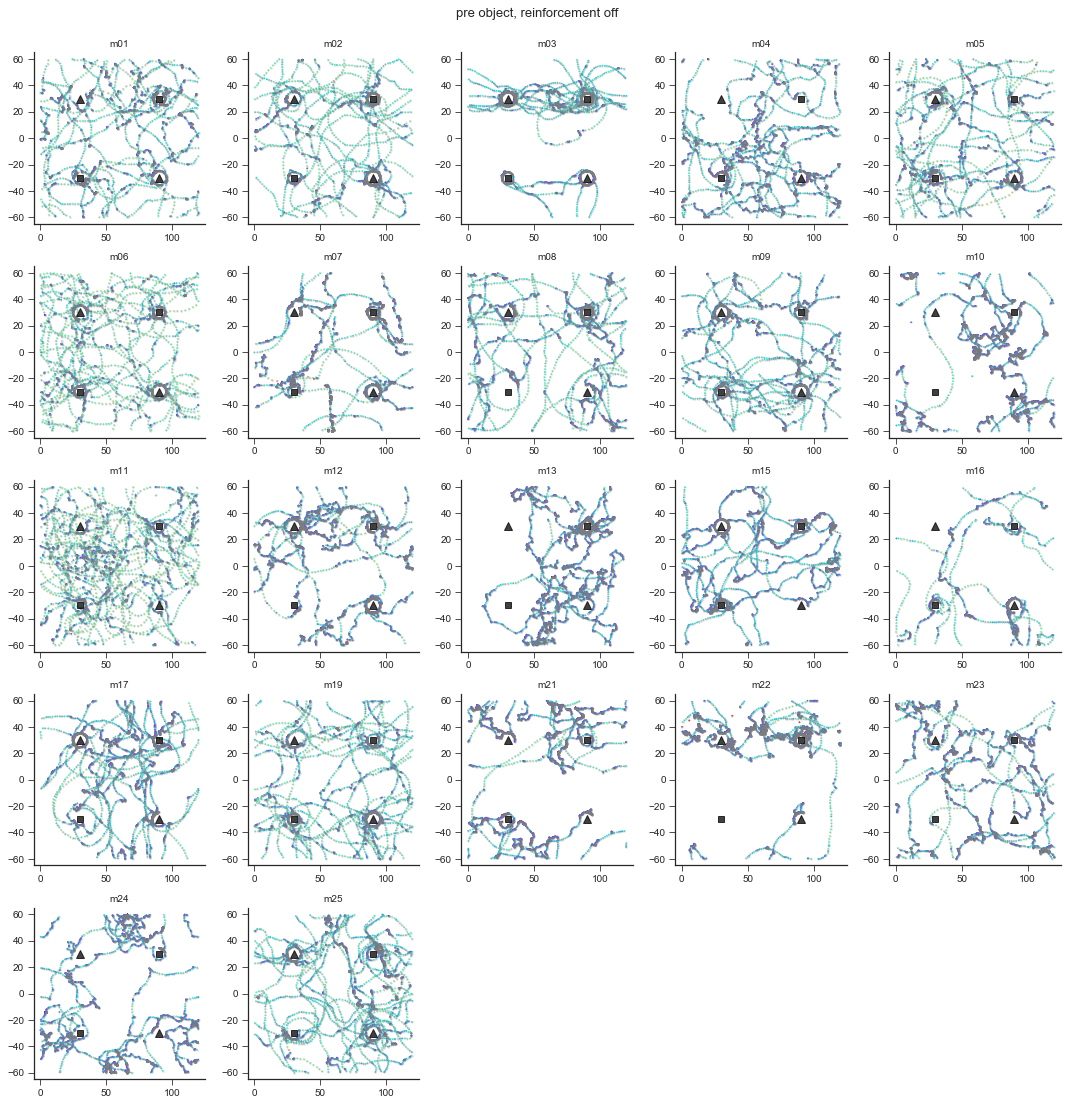

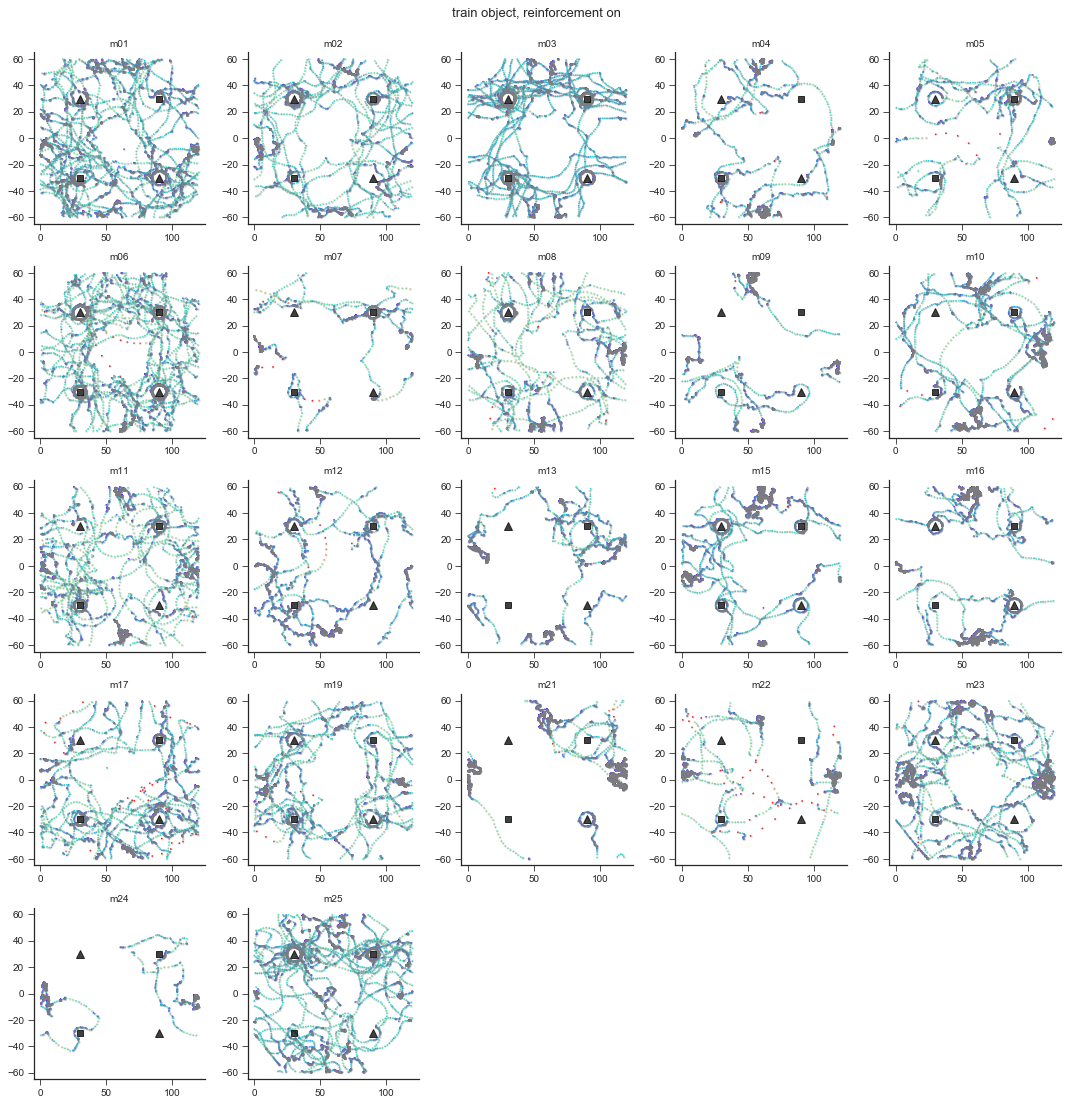

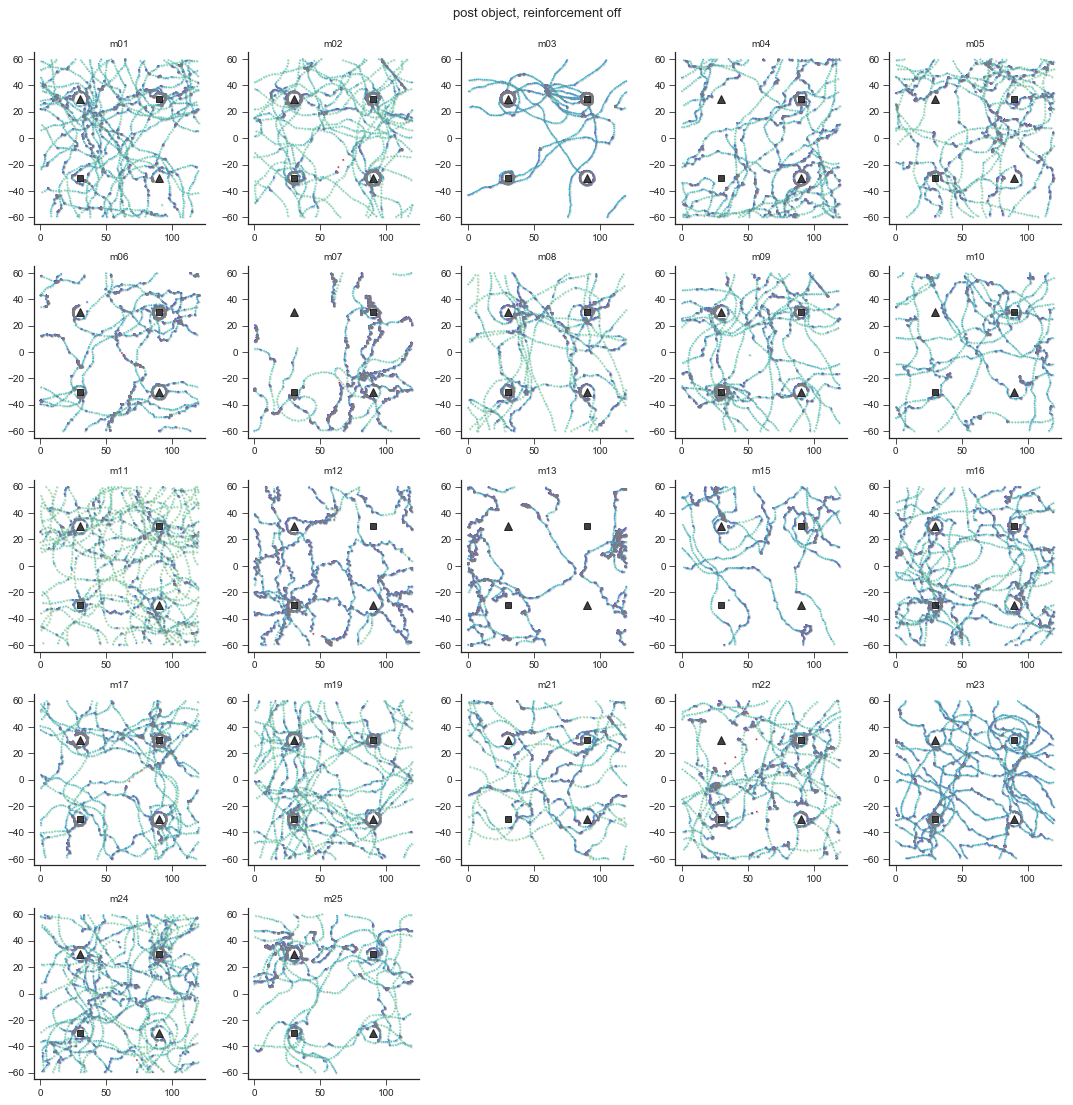

In [288]:
nrows = np.ceil(numFlies/5.0)
for ttind,trialtype in enumerate(trialName):
    multiflyTracePlot = plt.figure(figsize=(15,3*nrows))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' object, reinforcement ' + rZoneState[ttind] ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,5,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].values.squeeze()
        perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
        
        selectPts = range(0,len(perFlyX),3)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        
        if (visibilityState[ttind] == 'visible'):
            multiflyTracePlot_sbplt.plot(gridSize/2, -gridSize/2, marker='s', markersize=6, alpha=0.75, color='black')
            multiflyTracePlot_sbplt.plot(gridSize/2, gridSize/2, marker='^', markersize=8, alpha=0.75, color='black')
            multiflyTracePlot_sbplt.plot(3*gridSize/2, -gridSize/2, marker='^', markersize=8, alpha=0.75, color='black')
            multiflyTracePlot_sbplt.plot(3*gridSize/2, gridSize/2, marker='s', markersize=6, alpha=0.75, color='black')
        else:
            multiflyTracePlot_sbplt.plot(gridSize/2, -gridSize/2, marker='s', markersize=6, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=cyliColor)
            multiflyTracePlot_sbplt.plot(gridSize/2, gridSize/2, marker='^', markersize=8, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=coneColor)
            multiflyTracePlot_sbplt.plot(3*gridSize/2, -gridSize/2, marker='^', markersize=8, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=coneColor)
            multiflyTracePlot_sbplt.plot(3*gridSize/2, gridSize/2, marker='s', markersize=6, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=cyliColor)

        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-5, gridSize*2 + 5)
        multiflyTracePlot_sbplt.set_ylim(-5-gridSize, gridSize + 5)
        
    multiflyTracePlot.tight_layout()
    
    multiflyTracePlot.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ trialtype +'_trial'+ rZoneState[ttind]
                              +'_traceVeloColored_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Velocity distribution

In [289]:
histRangeVT = (vTransTH, 30)
histRangeVR = (-5,5)
numBins = 31

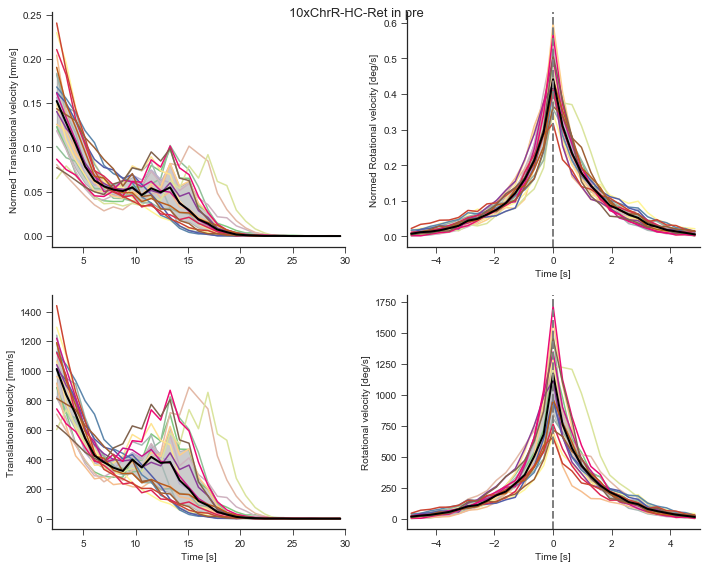

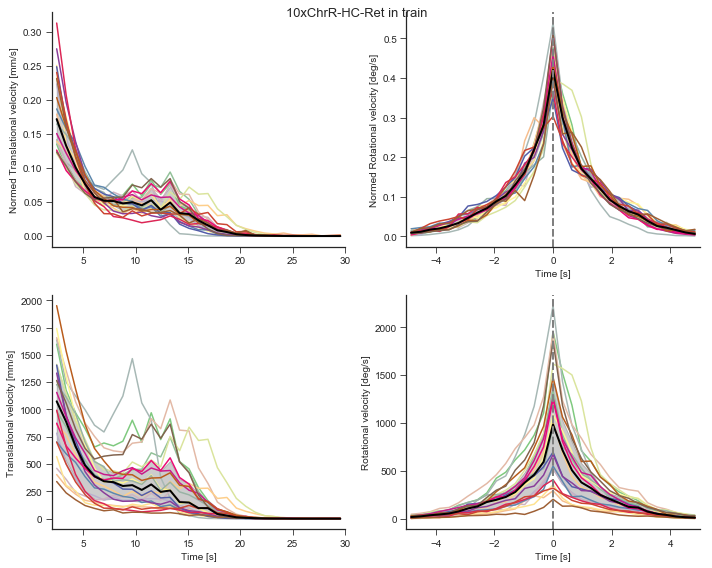

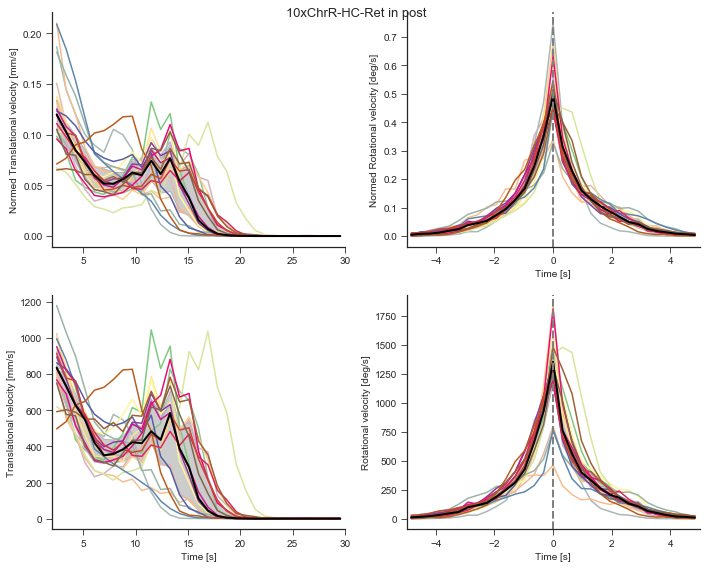

In [290]:
for tind, tname in enumerate(trialName):
    scene_df = FOAllFlies_df.query('trialtype == "' + tname + '"')
    titleString = genotype+' in '+ tname
    
    walkingFig = plotWalkingVelocityDistr(scene_df, flyIDs, keyind_mov, keyind_vT, keyind_vR, flyCMap,
                                 histRangeVT, histRangeVR,numBins, numFlies)
    walkingFig.suptitle(titleString, fontsize=13)
    walkingFig.tight_layout()

    walkingFig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotype + '_walingVelocities_'+tname+\
                       '_medianIQR_n'+str(numFlies) +selectionTag+'.pdf', format = 'pdf')

## Residency

### 2D (cartesian) residency

Plot directory already exists


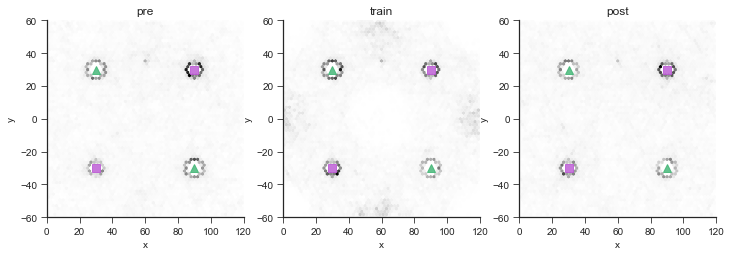

In [291]:
# plot parameter
numBins = 60

hexplotfig = plt.figure(figsize=(12,4))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPosMA = np.asarray(FOAllFlies_df.query(querystring)['xPosInMiniarena']).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring)['yPosInMiniarena']).squeeze()
    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys',linewidths=0,vmin=0)
    plt.xlabel('x'); plt.ylabel('y')
    
    landmarksInSquareTile(ax, LMcoords, LMcols)
            
    ax.set_title(trialName[trial])
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_residencyMA_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf')

### 1D radial residency close around objects

In [292]:
resdf_keylist_short = ['flyID','trial','trialtype','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2cone','dist2cyli','closestCone', 'closestCyli']
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)

for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        
        # compute distance to each landmark
        dist2cones = np.vstack(( np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1])),
                                 np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1])) ))
        dist2cylis = np.vstack(( np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1])),
                                 np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1])) ))

        # compute distance to closest landmark
        closestCone = np.argmin(dist2cones, axis=0)
        closestCyli = np.argmin(dist2cylis, axis=0)
        
        dist2closestCone = np.min(dist2cones, axis=0)
        dist2closestCyli = np.min(dist2cylis, axis=0)
        

        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closestCone)
        tmpdf.insert(2,'dist2cyli', dist2closestCyli)
        
        tmpdf.insert(3,'closestCone', closestCone)
        tmpdf.insert(4,'closestCyli', closestCyli)
        
        residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

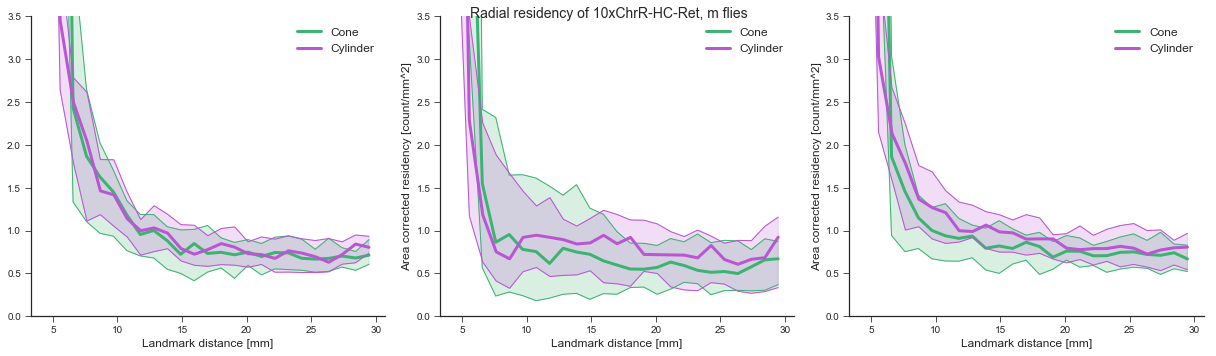

In [293]:
movementFilter = 'moving > 0'
histMax = (30,30)
histMin = (5,4) # adjust to LM base width
numBins = (25, 26)
varStyle = 'iqr' #'std', 'iqr'

LMcols = [coneColor,cyliColor]
LMnames = ['Cone', 'Cylinder']

keyind_dCone = resdf_keylist.index('dist2cone')
keyind_dCyli = resdf_keylist.index('dist2cyli')

# linear residency
radResFig = plt.figure(figsize=(17,5))
radResFig = oneDimResidencyWithVar_2LM_df(radResFig, residency_df, flyIDs, trialName,keyind_dCone, keyind_dCyli,
                                          movementFilter, numBins, histMin, histMax, 1, varStyle, LMcols, LMnames)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

In [294]:
# For shift control:
residencyShift_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)
for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        
        xtrial = xtrial+gridSize/2
        xtrial[xtrial>2*gridSize] = xtrial[xtrial>2*gridSize]-2*gridSize
        ytrial = ytrial-gridSize/2
        ytrial[ytrial<-gridSize] = ytrial[ytrial<-gridSize]+2*gridSize
        
        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )
        for obj in range(numLM):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closest[0,:])
        tmpdf.insert(2,'dist2cyli', dist2closest[1,:])
        
        residencyShift_df = residencyShift_df.append(tmpdf)

residencyShift_df = residencyShift_df[resdf_keylist]

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


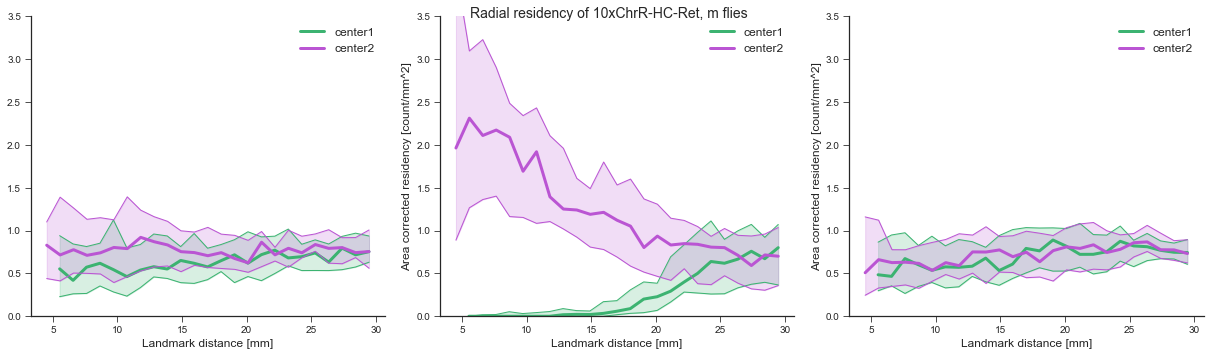

In [295]:
# Residency around center of landmark tile
radResFig = plt.figure(figsize=(17,5))
radResFig = oneDimResidencyWithVar_2LM_df(radResFig, residencyShift_df, flyIDs, trialName,resdf_keylist.index('dist2cone'),
                                          resdf_keylist.index('dist2cyli'),movementFilter, numBins, histMin, histMax,
                                          1, varStyle, LMcols, ['center1', 'center2'])
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_center-radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Visit-based analysis

In [296]:
makePlots = False#True

coneVisitFreq = np.zeros((len(flyIDs),len(trialName)))
cyliVisitFreq = np.zeros((len(flyIDs),len(trialName)))

coneVisitCount = np.zeros((len(flyIDs),len(trialName)))
cyliVisitCount = np.zeros((len(flyIDs),len(trialName)))

coneVisitLength = np.zeros((len(flyIDs),len(trialName)))
cyliVisitLength = np.zeros((len(flyIDs),len(trialName)))


# Plot individual traces
if exists(analysisDir + 'reinforcementEffect/'):
    if not exists(analysisDir + 'reinforcementEffect/individualFlies/'):
        mkdir(analysisDir + 'reinforcementEffect/individualFlies/')
else:
    mkdir(analysisDir + 'reinforcementEffect/')
    mkdir(analysisDir + 'reinforcementEffect/individualFlies/')

for fly in range(len(flyIDs)):
    if makePlots:
        visitFig, visitPlt = plt.subplots(len(trialName), 2, figsize=(10,10), gridspec_kw={"width_ratios":[1,1]})
    
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,timeTrial,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,timeTrial,visitRad)
        
        coneVisitFreq[fly,trial] = np.sum(entriesCone)/(timeTrial[-1]/60.0)
        cyliVisitFreq[fly,trial] = np.sum(entriesCyli)/(timeTrial[-1]/60.0)
        
        coneVisitCount[fly,trial] = np.sum(entriesCone)
        cyliVisitCount[fly,trial] = np.sum(entriesCyli)
        
        coneVisitLength[fly,trial] = np.sum(visitTCone)
        cyliVisitLength[fly,trial] = np.sum(visitTCyli)
            
        if makePlots:
            visitPlt[trial,0].plot(xPosTrial[entriesCone>0],yPosTrial[entriesCone>0],'o',color=coneColor,markersize=5)
            visitPlt[trial,0].plot(xPosTrial[entriesCyli>0],yPosTrial[entriesCyli>0],'o',color=cyliColor,markersize=5)

            visitPlt[trial,0].scatter(xPosTrial[evTrial>0],yPosTrial[evTrial>0],s=6,c=evTrial[evTrial>0],
                             cmap='hot',edgecolors='none',alpha=0.8,vmin=0,vmax=50)

            for obj in range(2):
                visitPlt[trial,0].plot(cyliCoords[obj][0], cyliCoords[obj][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
                visitPlt[trial,0].plot(coneCoords[obj][0], coneCoords[obj][1], marker='^', markersize=10, alpha=0.8, color=coneColor)

            visitPlt[trial,0].set_aspect('equal')
            visitPlt[trial,0].set_ylabel(trialtype)
            myAxisTheme(visitPlt[trial, 0])

            visitPlt[trial,1].plot(timeTrial,np.cumsum(entriesCone),color=coneColor)
            visitPlt[trial,1].plot(timeTrial,np.cumsum(entriesCyli),color=cyliColor)
            myAxisTheme(visitPlt[trial,1])

    
    if makePlots:
        visitFig.savefig(analysisDir + 'reinforcementEffect/individualFlies/'+ genotype +'_'+flyIDs[0][0]
                           +'_effectOnVisits_visitRad'+str(visitRad)+'mm_fly'+ flyIDs[fly] +'.pdf', format='pdf')

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in minimum


### Shared settings for plots

In [297]:
# Settings for boxplots of all three trials:

objBoxColors = [['lightgreen','seagreen','mediumseagreen'],
                ['palevioletred','darkmagenta','mediumorchid']] #for spec. objects
BoxColors = ['grey','slateblue','royalblue'] # for ratio between objects

trialColors = ['darkseagreen', 'darkviolet','teal']
trialMarkers = ['d','*','o']

offsets = [1.3, 1.3, 1.3]

boxalpha = 0.5
linealpha=0.5

allTrialFigSize = (12,4)
twoTrialFigSize = (16,4)

In [298]:
# Settings for boxplots of pre and post trial only
objBoxColors_pp = [['lightgreen','mediumseagreen'],
                   ['palevioletred','mediumorchid']]
BoxColors_pp = ['grey','royalblue'] 
offsets_pp = [1.32, 0.68]

### Visit count

Plot directory already exists


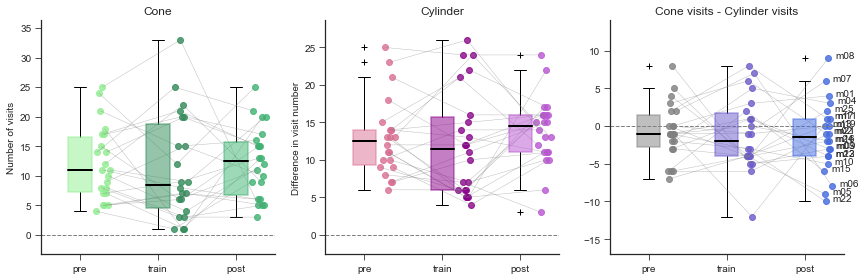

In [299]:
bpFig = plt.figure(figsize=allTrialFigSize)

VisitCount = visitCount
VisitCountRatio = visitCount[0]-visitCount[1]

for objtype in range(len(LMNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], boxalpha, linealpha, VisitCount[objtype], 
                              flyIDs, offsets, trialName, plotLabels=False)

    objBoxPlt.set_ylabel('Number of visits')
    bpPlt.set_title(LMNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, boxalpha, linealpha, VisitCountRatio, flyIDs, offsets, 
                            trialName, plotLabels=True)

bpPlt.set_ylim((-5+np.min(VisitCountRatio),5+np.max(VisitCountRatio)))
objBoxPlt.set_ylabel('Difference in visit number')
bpPlt.set_title('Cone visits - Cylinder visits')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Visit frequency [1/min]

Plot directory already exists


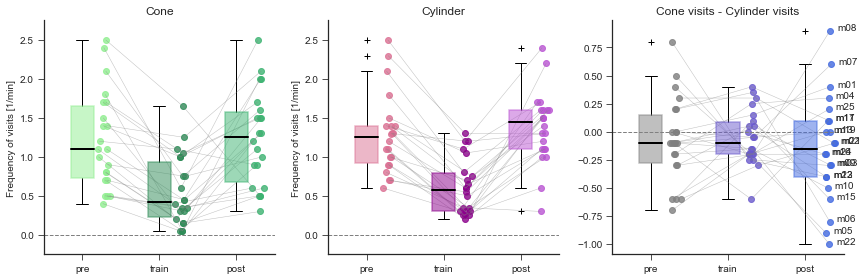

In [300]:
VisitFreq = visitFreq
VisitFreqRatio = visitFreq[0]-visitFreq[1]

bpFig = plt.figure(figsize=allTrialFigSize)

for objtype in range(len(LMNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], boxalpha, linealpha, VisitFreq[objtype],
                             flyIDs, offsets, trialName, plotLabels=False)

    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(LMNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, boxalpha, linealpha, VisitFreqRatio,flyIDs, offsets, 
                            trialName, plotLabels=True)

bpPlt.set_ylim((-0.1*np.max(VisitFreqRatio)+np.min(VisitFreqRatio),
                0.1*np.max(VisitFreqRatio)+np.max(VisitFreqRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitFrequency_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

p = 0.561067444915
Plot directory already exists


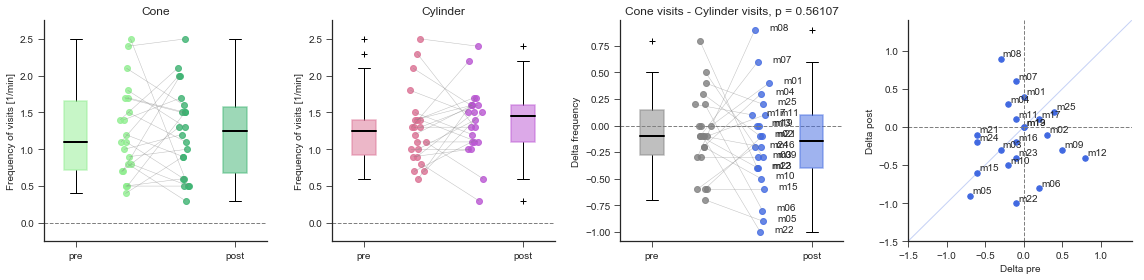

In [301]:
# compare just pre and post

VisitFreq = [visitFreq[0][:,[0,2]],visitFreq[1][:,[0,2]]]
VisitFreqRatio = visitFreq[0][:,[0,2]]-visitFreq[1][:,[0,2]]

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(len(LMNames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors_pp[objtype], boxalpha, linealpha, VisitFreq[objtype],
                             flyIDs, offsets_pp, trialName, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(LMNames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors_pp, boxalpha, linealpha, VisitFreqRatio, flyIDs, offsets_pp, trialName, plotLabels=True)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.1*np.max(VisitFreqRatio)+np.min(VisitFreqRatio),
                0.1*np.max(VisitFreqRatio)+np.max(VisitFreqRatio)))
bpPlt.set_ylabel('Delta frequency')

from scipy import stats as sts
tval, pval = sts.ttest_rel(VisitFreqRatio[:,0], VisitFreqRatio[:,1],
              axis=0, nan_policy='propagate')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,5)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitFreqRatio, flyIDs, BoxColors_pp[-1])

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

np.savetxt(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
           +'_visitFrequency_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag+'.csv', VisitFreqRatio,delimiter=',')

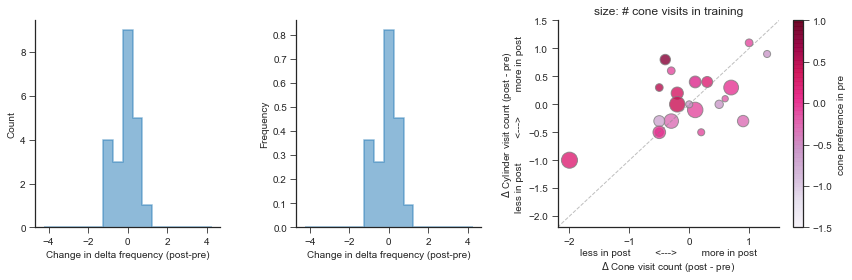

In [302]:
# Learning-induced shift in visit freuqency
histrange = (-4.25,4.25)
nbins = 17

normedvals = [False, True]
labelvals = ['Count','Frequency']

shiftFig, axs = plt.subplots(1,3,figsize=(12,4), gridspec_kw={'width_ratios':[1,1,1.5]})

for i in range(2):
    axs[i].hist(VisitFreqRatio[:,1]-VisitFreqRatio[:,0], range=histrange, bins=nbins, histtype = 'step',
                  normed=normedvals[i], fill=BoxColors_pp[-1],linewidth=1.5, align='mid', alpha=boxalpha)
    axs[i].set_xlabel('Change in delta frequency (post-pre)')
    axs[i].set_ylabel(labelvals[i])

#scatter plot of cone-change vs. cylinder-chance visits per trial
coneShift = visitFreq[0][:,2]-visitFreq[0][:,0]
cyliShift = visitFreq[1][:,2]-visitFreq[1][:,0]
cb = axs[2].scatter(coneShift, cyliShift, s=visitCount[1][:,1]*10, c=visitFreq[0][:,0]-visitFreq[1][:,0], 
               cmap='PuRd',vmin=-1.5, vmax=1, alpha=0.8, edgecolor='grey')
plt.colorbar(cb, ax=axs[2],label='cone preference in pre')
maxplt = 0.2 + np.nanmax((coneShift, cyliShift))
minplt = -0.2 + np.nanmin((coneShift, cyliShift))
axs[2].plot([minplt,maxplt],[minplt,maxplt],linewidth=1,color='grey',linestyle='dashed',alpha=0.5)
axs[2].set_xlabel('less in post         <--->         more in post\n$\Delta$ Cone visit count (post - pre)')
axs[2].set_ylabel('$\Delta$ Cylinder visit count (post - pre)\nless in post         <--->         more in post')
axs[2].set_xlim(minplt, maxplt)
axs[2].set_ylim(minplt, maxplt)
axs[2].set_title('size: # cone visits in training')

[myAxisTheme(axs[i]) for i in range(3)]
shiftFig.tight_layout()

shiftFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePostHist_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Vistit frequency shifts pre --> post

The angular mean is 78.690067526 degrees.


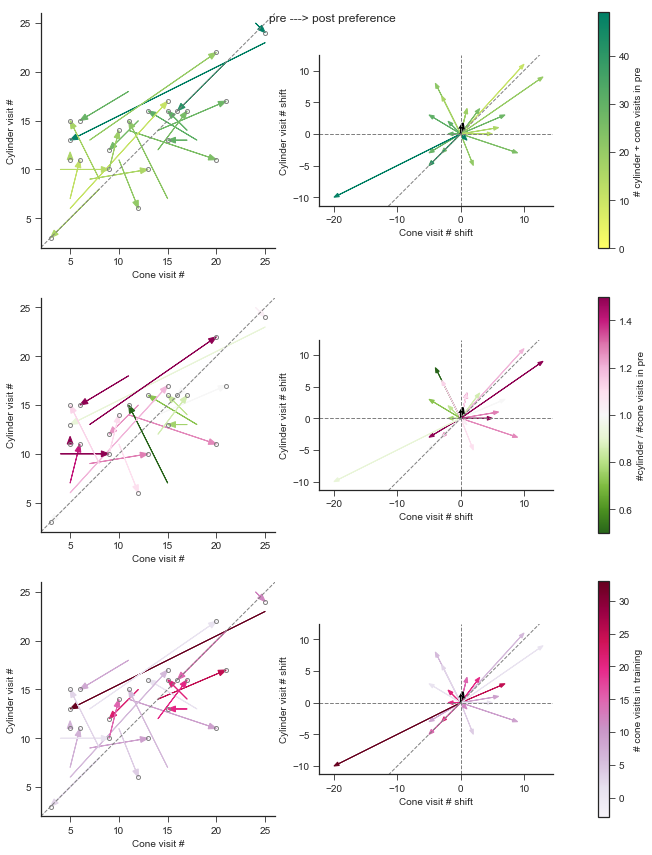

In [303]:
coneTCount = np.stack((visitCount[0][:,0],visitCount[0][:,2]), axis=1)
cyliTCount = np.stack((visitCount[1][:,0],visitCount[1][:,2]), axis=1)

# Plot.........

shiftFig, axs = plt.subplots(3,3,figsize=(9,12), gridspec_kw={'width_ratios':[3,3,0.15]})

headw=0.6
headl=0.8

import matplotlib.colorbar as mplcb

for cm in range(3):
    #scatter plot of cone-change vs. cylinder-chance visits per trial
    
    if cm == 0:
        #pre vist count cmap: cylinder + cone visits in pre
        cNorm  = colors.Normalize(vmin=0, vmax=np.nanmax(visitCount[1][:,0]+visitCount[0][:,0]))
        preVisitCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='summer_r')

        cb = mplcb.ColorbarBase(axs[cm,2], cmap='summer_r', norm=cNorm, orientation='vertical')
        cblab = '# cylinder + cone visits in pre'

    elif cm == 1:
        #pre vist preference cmap: cylinder / cone visits in pre
        ratio = visitCount[1][:,0]/visitCount[0][:,0]
        lim = np.max([abs(np.min(ratio[np.isfinite(ratio)])), np.max(ratio[np.isfinite(ratio)])])
        cNorm  = colors.Normalize(vmin=-lim+4, vmax=lim-2)
        prePrefCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='PiYG_r')

        cb = mplcb.ColorbarBase(axs[cm,2], cmap='PiYG_r', norm=cNorm, orientation='vertical')
        cblab = '#cylinder / #cone visits in pre'
    
    elif cm == 2:
        #reinforcement cmap: cone visits in training
        cNorm  = colors.Normalize(vmin=-3, vmax=np.nanmax(visitCount[0][:,1]))
        reinfCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='PuRd')

        cb = mplcb.ColorbarBase(axs[cm,2], cmap='PuRd', norm=cNorm, orientation='vertical')
        cblab = '# cone visits in training'
        
    avShift = [0,0]
    for fly in range(numFlies):
        if cm==0:
            currcol = preVisitCMap.to_rgba(visitCount[1][fly,0]+visitCount[0][fly,0]) # pre visit count
            ecol = currcol
        elif cm==1:
            currcol = prePrefCMap.to_rgba(ratio[fly]) # pre visit preference
            ecol = currcol#'grey'
        elif cm==2:
            currcol = reinfCMap.to_rgba(visitCount[0][fly,1]) #training cone visits
            ecol = currcol

        flyCo = coneTCount[fly,:]
        flyCy = cyliTCount[fly,:]
        axs[cm, 0].plot(flyCo[1], flyCy[1],markersize=8, marker='.', markerfacecolor='none', markeredgecolor='gray', alpha=1)
        
        if (flyCo[0] == flyCo[1] and flyCy[0] == flyCy[1]):
            headlinc = False
        else:
            headlinc = True

        axs[cm, 0].arrow(flyCo[0], flyCy[0], flyCo[1]-flyCo[0], flyCy[1]-flyCy[0], head_width=headw,
                     head_length=headl, fc=currcol, ec=ecol, length_includes_head = headlinc)

        if (flyCo[1]-flyCo[0] + flyCo[1]-flyCo[0]): headlinc = True
        else: headlinc = False
        
        axs[cm,1].arrow(0,0, flyCo[1]-flyCo[0], flyCy[1]-flyCy[0], head_width=headw, head_length=headl,
                     fc=currcol, ec=ecol, length_includes_head = headlinc)

        avShift[0] = avShift[0]+ flyCo[1]-flyCo[0]
        avShift[1] = avShift[1]+ flyCy[1]-flyCy[0]
        
    maxplt = 1 + np.nanmax((coneTCount, cyliTCount))
    minplt = -1 + np.nanmin((coneTCount, cyliTCount))
    axs[cm,0].set_xlim(minplt, maxplt); axs[cm,0].set_ylim(minplt, maxplt)
    axs[cm,0].plot([minplt,maxplt],[minplt,maxplt],linewidth=1,color='grey',linestyle='dashed')
    axs[cm,0].set_xlabel('Cone visit #');
    axs[cm,0].set_ylabel('Cylinder visit #')

    minplt = [-0.3 + np.nanmin((coneTCount[:,1]-coneTCount[:,0])),-0.3 + np.nanmin((cyliTCount[:,1]-cyliTCount[:,0]))]
    maxplt = [0.3 + np.nanmax((coneTCount[:,1]-coneTCount[:,0])),0.3 + np.nanmax((cyliTCount[:,1]-cyliTCount[:,0]))]

    axs[cm,1].arrow(0,0, float(avShift[0]/numFlies), float(avShift[1]/numFlies), head_width=headw, head_length=headl, 
                 fc='none', ec='k', length_includes_head = False, linewidth=2)
    axs[cm,1].plot([min(minplt),max(maxplt)],[min(minplt),max(maxplt)],linewidth=1,color='grey',linestyle='dashed')
    axs[cm,1].axhline(y=0, linewidth=1, color='grey', linestyle='dashed')
    axs[cm,1].axvline(x=0, linewidth=1, color='grey', linestyle='dashed')

    axs[cm,1].set_xlim(minplt[0]*1.1, maxplt[0]*1.1)
    axs[cm,1].set_ylim(minplt[1]*1.1, maxplt[1]*1.1)
    axs[cm,1].set_xlabel('Cone visit # shift')
    axs[cm,1].set_ylabel('Cylinder visit # shift')
    
    cb.set_label(cblab)

    for i in range(2):
        myAxisTheme(axs[cm,i])
        axs[cm,i].set_aspect('equal')
        
shiftFig.suptitle('pre ---> post preference')

print('The angular mean is {} degrees.').format(180/np.pi*np.arctan((avShift[1]/numFlies)/(avShift[0]/numFlies)))

shiftFig.tight_layout()
shiftFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePostFlyShift_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Visit counts ~ average per fly velocities

Plot directory already exists


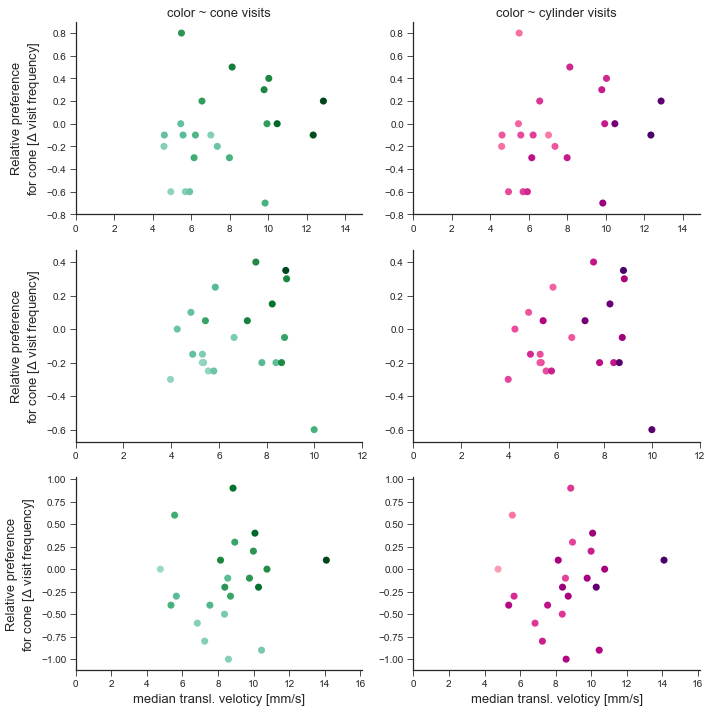

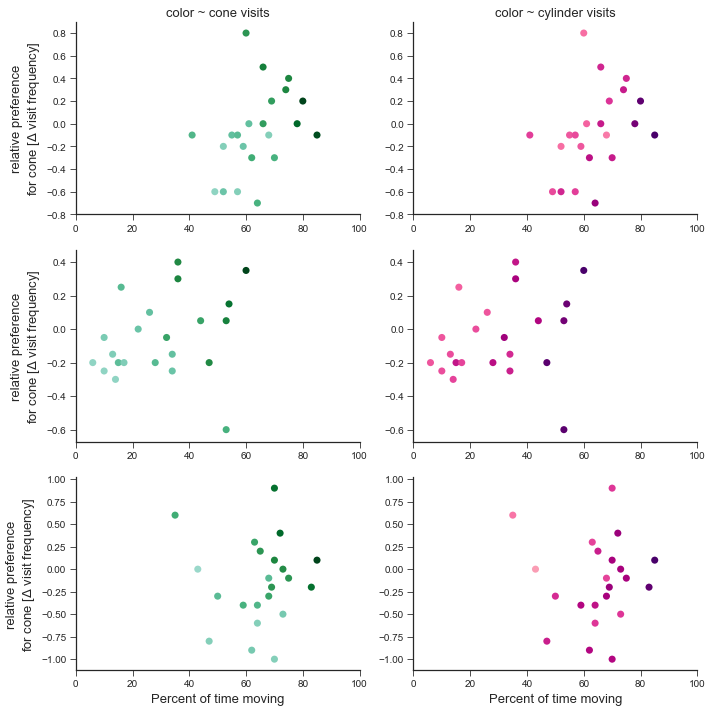

In [304]:
# Relation of visit count to walking velocity
visitVTFig, axsVT = plt.subplots(len(trialName),2,figsize=(10,10), gridspec_kw = dict(width_ratios = [2,2]))
# Relation of visit count to movement
visitMovFig, axsMov = plt.subplots(len(trialName),2,figsize=(10,10), gridspec_kw = dict(width_ratios = [2,2]))

for tind, trialtype in enumerate(trialName):
    vTrans = np.zeros((len(flyIDs)))
    vRot = np.zeros((len(flyIDs)))
    pcMov = np.zeros((len(flyIDs)))
    
    if not tind:
        axsVT[tind,0].set_title('color ~ cone visits',fontsize=13)
        axsVT[tind,1].set_title('color ~ cylinder visits',fontsize=13)
        axsMov[tind,0].set_title('color ~ cone visits',fontsize=13)
        axsMov[tind,1].set_title('color ~ cylinder visits',fontsize=13)

    for fly in range(len(flyIDs)):
        querystring = '(flyID == "'+flyIDs[fly]+'") & (trialtype=="' + trialtype + '")'
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
        perFlyvR = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].values.squeeze()
        perFlymov = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].values.squeeze()

        tSt = 0
        tEnd = len(timeTrial)
        vt = perFlyvT[tSt:tEnd]
        vr = perFlyvR[tSt:tEnd]
        mov = perFlymov.astype('bool')[tSt:tEnd] 
        vTrans[fly] = np.squeeze(np.nanmedian(vt[mov]))
        vRot[fly] = np.squeeze(np.nanmedian(abs(vr[mov])))
        pcMov[fly] = 100*sum(mov)/len(mov)
        
    relPref = np.squeeze(visitFreq[0][:,tind])-np.squeeze(visitFreq[1][:,tind])

    # Relation of visit count to walking velocity
    axsVT[tind,0].scatter(vTrans,relPref,s=50,c=visitFreq[0][:,tind],cmap='BuGn',vmin=-1,edgecolor='none')
    axsVT[tind,1].scatter(vTrans,relPref,s=50,c=visitFreq[1][:,tind],cmap='RdPu',vmin=-1,edgecolor='none')
    
    # Relation of visit count to movement
    axsMov[tind,0].scatter(pcMov,relPref,s=50,c=visitFreq[0][:,tind],cmap='BuGn',vmin=-1,edgecolor='none')
    axsMov[tind,1].scatter(pcMov,relPref,s=50,c=visitFreq[1][:,tind],cmap='RdPu',vmin=-1,edgecolor='none')

    
    axsVT[tind,0].set_ylabel('Relative preference\nfor cone [$\Delta$ visit frequency]',fontsize=13)
    axsMov[tind,0].set_ylabel('relative preference\nfor cone [$\Delta$ visit frequency]',fontsize=13)
    
    for ax in axsVT[tind,:]:
        if tind == 2:
            ax.set_xlabel('median transl. veloticy [mm/s]',fontsize=13)
        ax.set_xlim(0, (max(vTrans)+2))
        myAxisTheme(ax)

    for ax in axsMov[tind,:]:
        ax.set_xlim(0, 100)
        if tind == 2:
            ax.set_xlabel('Percent of time moving',fontsize=13)
        myAxisTheme(ax)

visitVTFig.tight_layout()
visitMovFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')

visitVTFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                   +'_visitFreqAndVelo_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf')

visitMovFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                   +'_visitFreqAndMov_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf')

### Visit length

Plot directory already exists


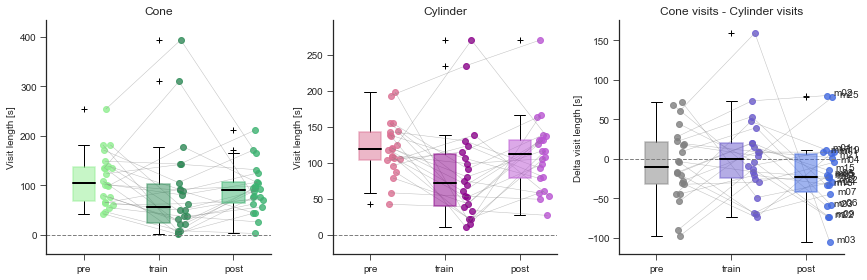

In [305]:
conelength = np.copy(visitLength[0]); cylilength = np.copy(visitLength[1])
conelength[np.isnan(conelength)] = 0; cylilength[np.isnan(cylilength)] = 0
VisitLength = [conelength,cylilength]
VisitLengthRatio = conelength-cylilength

bpFig = plt.figure(figsize=allTrialFigSize)

for objtype in range(numLM):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], boxalpha, linealpha, VisitLength[objtype],
                             flyIDs, offsets, trialName, plotLabels=False)

    bpPlt.set_ylabel('Visit length [s]')
    bpPlt.set_title(LMNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, boxalpha, linealpha, VisitLengthRatio,flyIDs, offsets, 
                            trialName, plotLabels=True)

bpPlt.set_ylim((-0.1*np.max(VisitLengthRatio)+np.min(VisitLengthRatio),
                0.1*np.max(VisitLengthRatio)+np.max(VisitLengthRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')
bpPlt.set_ylabel('Delta visit length [s]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

p = 0.348862629801
Plot directory already exists


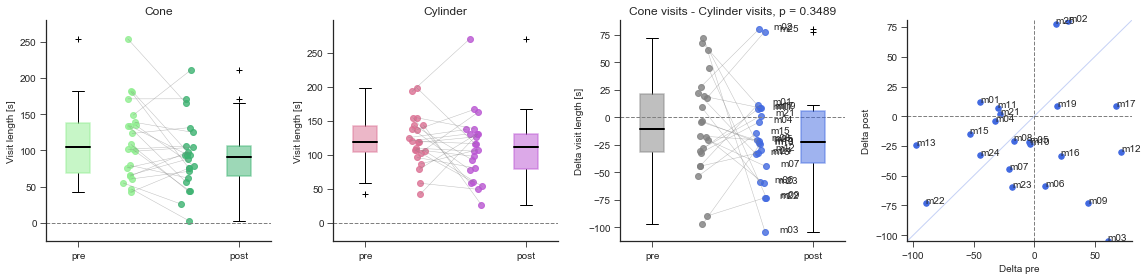

In [306]:
# compare just pre and post
conelength = np.copy(visitLength[0][:,[0,2]]); cylilength = np.copy(visitLength[1][:,[0,2]])
conelength[np.isnan(conelength)] = 0; cylilength[np.isnan(cylilength)] = 0
VisitLength = [conelength,cylilength]
VisitLengthRatio = conelength-cylilength

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(numLM):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors_pp[objtype], boxalpha, linealpha, VisitLength[objtype],
                             flyIDs, offsets_pp, trialName, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylabel('Visit length [s]')
    bpPlt.set_title(LMNames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors_pp, boxalpha, linealpha, VisitLengthRatio, flyIDs, offsets_pp,
                            trialName, plotLabels=True)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.1*np.max(VisitLengthRatio)+np.min(VisitLengthRatio),
                0.1*np.max(VisitLengthRatio)+np.max(VisitLengthRatio)))
bpPlt.set_ylabel('Delta visit length [s]')

from scipy import stats as sts
tval, pval = sts.ttest_rel(VisitLengthRatio[:,0], VisitLengthRatio[:,1],
              axis=0, nan_policy='propagate')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitLengthRatio, flyIDs, BoxColors_pp[-1])

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                 +selectionTag+'.pdf', format='pdf')

np.savetxt(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
           +'_visitLength_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag+'.csv', VisitFreqRatio,delimiter=',')

### Generate boxplot of visits over 5 min blocks

In [307]:
trial5min = [2,4,2]
BoxColors_5min = [[BoxColors[i]]*trial5min[i] for i in range(3)]
blockNames_5min = [[trialName[i]+' '+ str(t+1) for t in range(trial5min[i])]  for i in range(3)]
objBoxColors_5min_1 = [[objBoxColors[0][i]]*trial5min[i] for i in range(3)]
objBoxColors_5min_2 = [[objBoxColors[1][i]]*trial5min[i] for i in range(3)]
BoxColors_5min = [item for sublist in BoxColors_5min for item in sublist]
blockNames_5min = [item for sublist in blockNames_5min for item in sublist]
objBoxColors_5min = [[item for sublist in objBoxColors_5min_1 for item in sublist],
                    [item for sublist in objBoxColors_5min_2 for item in sublist]]

In [308]:
# Generate landmark visit count over 5 min blocks
visitCount_5min = np.zeros((numLM, numFlies, sum(trial5min)))
visitLength_5min = np.zeros((numLM, numFlies, sum(trial5min)))

for fly in range(numFlies):
    blockcount = 0
    
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        for block in range(trial5min[trial]):
            entriesCone,_,visitTCone,_,_ = countvisits(dist2closestCone[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)],
                                                       timeTrial[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)],
                                                       visitRad)
            entriesCyli,_,visitTCyli,_,_ = countvisits(dist2closestCyli[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)],
                                                    timeTrial[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)],
                                                       visitRad)

            visitCount_5min[0, fly, block+blockcount] = np.sum(entriesCone)
            visitCount_5min[1, fly, block+blockcount] = np.sum(entriesCyli)

            visitLength_5min[0, fly, block+blockcount] = np.sum(visitTCone)
            visitLength_5min[1, fly, block+blockcount] = np.sum(visitTCyli)
            
        blockcount = blockcount + trial5min[trial]

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in minimum


Plot directory already exists


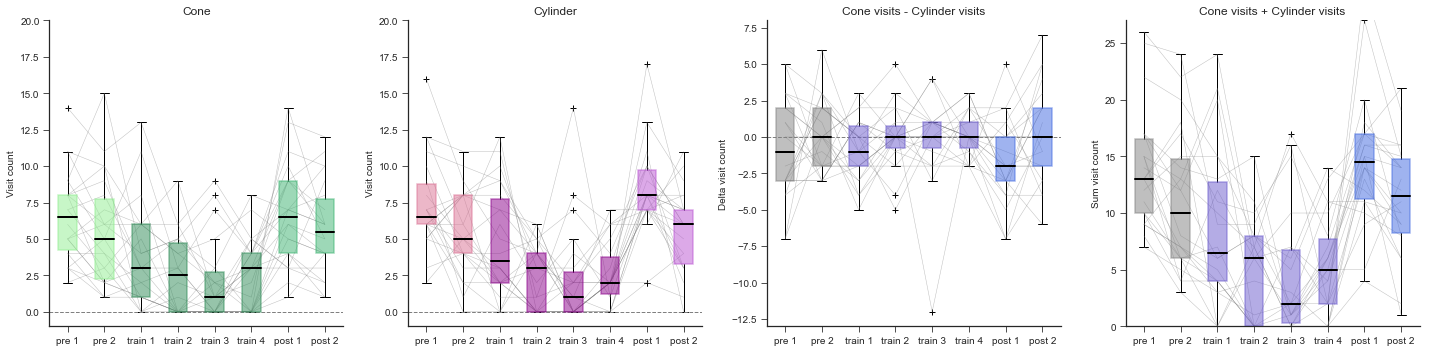

In [309]:
visitCountRatio_5min = visitCount_5min[0,:,:] - visitCount_5min[1,:,:]

bpFig, axs = plt.subplots(1,4,figsize=(20,5))

for objtype in range(numLM):    
    objBoxPlt = simpleBoxPlot(axs[objtype], objBoxColors_5min[objtype], boxalpha, linealpha, 
                              visitCount_5min[objtype,:,:], flyIDs, blockNames_5min)

    axs[objtype].set_ylabel('Visit count')
    axs[objtype].set_title(LMNames[objtype])
    axs[objtype].set_ylim(-1,20)

ratioBoxPlt = simpleBoxPlot(axs[2], BoxColors_5min, boxalpha, linealpha, visitCountRatio_5min, flyIDs,
                            blockNames_5min)

axs[2].set_ylim((np.min(visitCountRatio_5min)-1,np.max(visitCountRatio_5min)+1))
axs[2].set_title('Cone visits - Cylinder visits')
axs[2].set_ylabel('Delta visit count')


ratioBoxPlt = simpleBoxPlot(axs[3], BoxColors_5min, boxalpha, linealpha, visitCount_5min[0]+visitCount_5min[1], flyIDs,
                            blockNames_5min)
axs[3].set_ylim(0,np.max(visitCount_5min)+10)
axs[3].set_title('Cone visits + Cylinder visits')
axs[3].set_ylabel('Sum visit count')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount5min_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

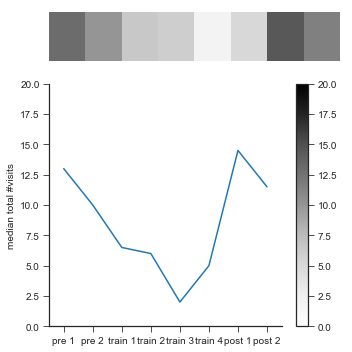

In [312]:
# Visualisation of median total visit count as heatmap
x = range(len(blockNames_5min))
y = np.median(visitCount_5min[0]+visitCount_5min[1],axis=0)

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(5,5), gridspec_kw={'height_ratios':{1,5}})

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
cb = ax.imshow(y[np.newaxis,:], cmap="Greys", aspect="auto", extent=extent,vmin=0, vmax=20)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])
ax.axis('off')
ax2.plot(x,y)
ax2.set_ylim(0,20)
plt.sca(ax2)
plt.xticks(x,blockNames_5min)
ax2.set_ylabel('median total #visits')
myAxisTheme(ax2)
plt.colorbar(cb, ax=ax2)

plt.tight_layout()
fig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount5minHeatMap_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Plot directory already exists


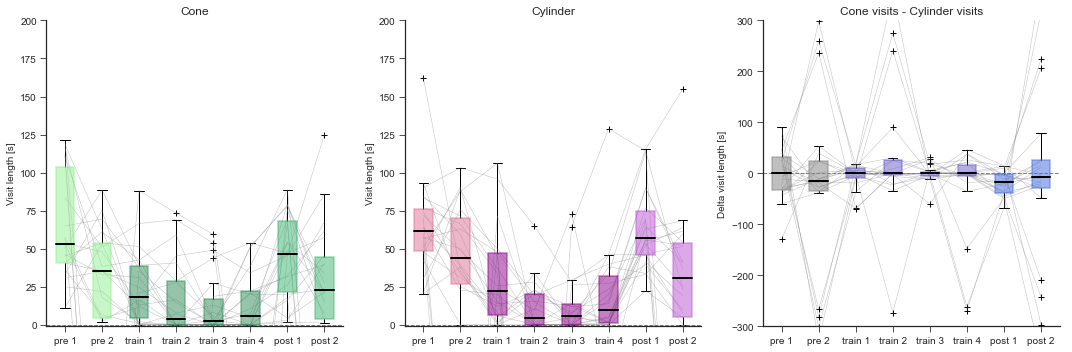

In [311]:
visitLength_5min_nan = visitLength_5min.copy()
visitLength_5min_nan[np.isnan(visitLength_5min_nan)] = 0

visitLengthRatio_5min = visitLength_5min_nan[0,:,:] - visitLength_5min_nan[1,:,:]

bpFig, axs = plt.subplots(1,3,figsize=(15,5))

for objtype in range(numLM):    
    objBoxPlt = simpleBoxPlot(axs[objtype], objBoxColors_5min[objtype], boxalpha, linealpha, 
                              visitLength_5min_nan[objtype,:,:], flyIDs, blockNames_5min)

    axs[objtype].set_ylabel('Visit length [s]')
    axs[objtype].set_title(LMNames[objtype])
    axs[objtype].set_ylim(-1,200)

ratioBoxPlt = simpleBoxPlot(axs[2], BoxColors_5min, boxalpha, linealpha, visitLengthRatio_5min, flyIDs,
                            blockNames_5min)

axs[2].set_ylim((-300, 300))
axs[2].set_title('Cone visits - Cylinder visits')
axs[2].set_ylabel('Delta visit length [s]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitLength5min_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Cumsum visit plot

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encou

Plot directory already exists


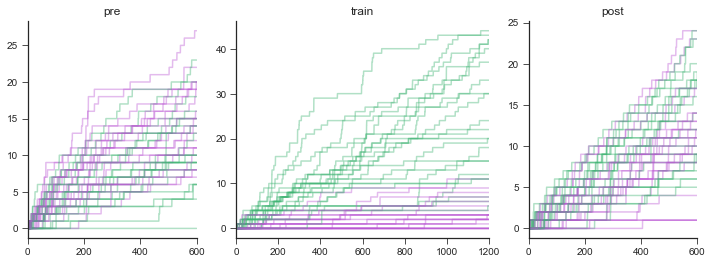

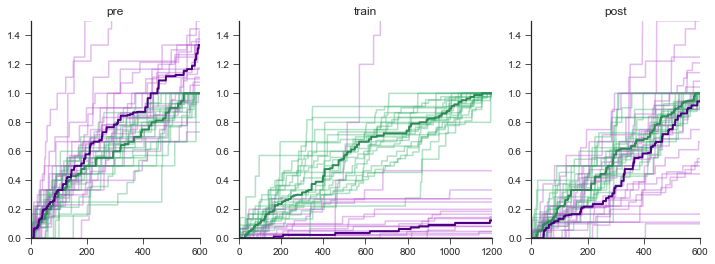

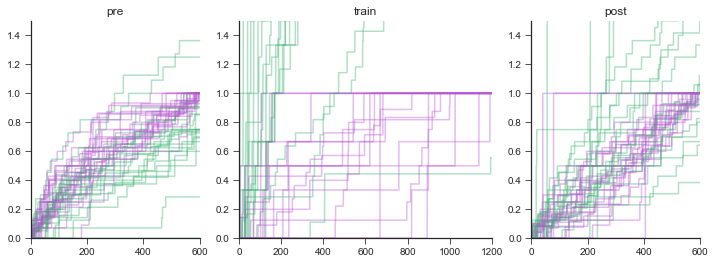

In [98]:
#NEEDS CLEAN UP

visitFig, cumsumVisitPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})
scaledVisitFig, scaledCumsumVisitPlts  = plt.subplots(1,len(trialName), figsize=(12,4),gridspec_kw = {'width_ratios':[1, 1.5, 1]})
revScaledVisitFig, revScaledCumsumVisitPlts  = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})

vistitAlphaScale = [10,10,10]

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    scaledConeVisits = np.nan*np.ones((numFlies, len(timeTrial)))
    scaledCyliVisits = np.nan*np.ones((numFlies, len(timeTrial)))
    
    for fly in range(numFlies):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,timeTrial,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,timeTrial,visitRad)
            
        alphaVal = 0.4

        cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone),color='mediumseagreen', alpha=alphaVal)
        cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli),color='mediumorchid', alpha=alphaVal)
        
        scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone)/sum(entriesCone),color='mediumseagreen', alpha=alphaVal)
        scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli)/sum(entriesCone),color='mediumorchid', alpha=alphaVal)
        
        scaledConeVisits[fly,:] = np.cumsum(entriesCone)/sum(entriesCone)
        scaledCyliVisits[fly,:] = np.cumsum(entriesCyli)/sum(entriesCone)
        
        #reverse scale
        revScaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone)/sum(entriesCyli),color='mediumseagreen', alpha=alphaVal)
        revScaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli)/sum(entriesCyli),color='mediumorchid', alpha=alphaVal)
        
    cumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitPlts[trial])
    cumsumVisitPlts[trial].set_title(trialtype)

    scaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    scaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(scaledConeVisits,axis=0),
                                      color = 'seagreen',linewidth=2)
    scaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(scaledCyliVisits,axis=0),
                                      color = 'indigo',linewidth=2)
    myAxisTheme(scaledCumsumVisitPlts[trial])
    scaledCumsumVisitPlts[trial].set_title(trialtype)
    scaledCumsumVisitPlts[trial].set_ylim(0,1.5)

    revScaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(revScaledCumsumVisitPlts[trial])
    revScaledCumsumVisitPlts[trial].set_title(trialtype)
    revScaledCumsumVisitPlts[trial].set_ylim(0,1.5)    
        
try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
scaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_coneScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
revScaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_cyliScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in minimum


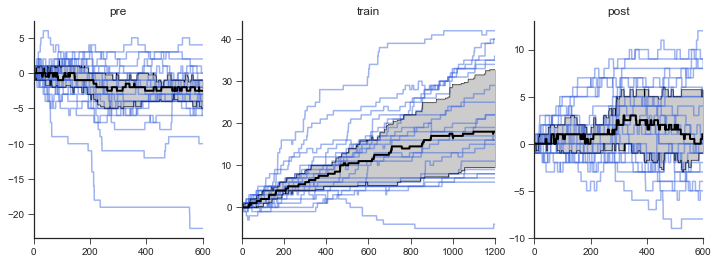

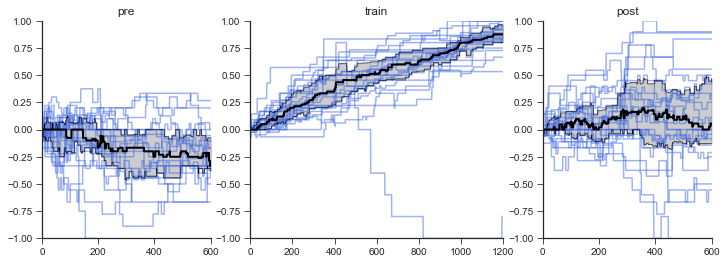

In [99]:
visitDiffFig, cumsumVisitDiffPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})
scaledVisitDiffFig, scaledCumsumVisitDiffPlts  = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    visitDiff = np.nan*np.ones((numFlies, len(timeTrial)))
    visitDiffNorm = np.nan*np.ones((numFlies, len(timeTrial)))
    
    for fly in range(numFlies):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,timeTrial,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,timeTrial,visitRad)

        visitDiff[fly] = np.cumsum(entriesCone)-np.cumsum(entriesCyli)
        visitDiffNorm[fly] = np.cumsum(entriesCone)/sum(entriesCone) - np.cumsum(entriesCyli)/sum(entriesCone)
        
        cumsumVisitDiffPlts[trial].plot(timeTrial,visitDiff[fly],color=BoxColors_pp[-1], alpha=0.5)
        scaledCumsumVisitDiffPlts[trial].plot(timeTrial,visitDiffNorm[fly] ,color=BoxColors_pp[-1], alpha=0.5)
    
    av = np.nanmedian(visitDiff,axis=0)
    [var1,var2] = np.nanpercentile(visitDiff, [25,75], axis=0)
    cumsumVisitDiffPlts[trial].plot(timeTrial,av,color='black', alpha=1, linewidth=2)
    cumsumVisitDiffPlts[trial].plot(timeTrial,var1,color='black', alpha=1, linewidth=0.5)
    cumsumVisitDiffPlts[trial].plot(timeTrial,var2,color='black', alpha=1, linewidth=0.5)
    cumsumVisitDiffPlts[trial].fill_between(timeTrial, var1, var2, color='black', alpha=0.2)
    
    av = np.nanmedian(visitDiffNorm,axis=0)
    [var1,var2] = np.nanpercentile(visitDiffNorm,[25,75], axis=0)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,av,color='black', alpha=1, linewidth=2)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,var1,color='black', alpha=1, linewidth=0.5)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,var2,color='black', alpha=1, linewidth=0.5)
    scaledCumsumVisitDiffPlts[trial].fill_between(timeTrial, var1, var2, color='black', alpha=0.2)
    
    cumsumVisitDiffPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitDiffPlts[trial])
    cumsumVisitDiffPlts[trial].set_title(trialtype)
    
    scaledCumsumVisitDiffPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(scaledCumsumVisitDiffPlts[trial])
    scaledCumsumVisitDiffPlts[trial].set_title(trialtype)
    scaledCumsumVisitDiffPlts[trial].set_ylim(-1,1)
        
visitDiffFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitDiffComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                     +selectionTag+'.pdf', format='pdf')
scaledVisitDiffFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_scaledCumVisitDiffComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                           +selectionTag+'.pdf', format='pdf')

### Visit radius ~ relative preference

In [100]:
visitRadii = np.linspace(6,30,13)
visitRadii

array([  6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,  26.,
        28.,  30.])

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in minimum


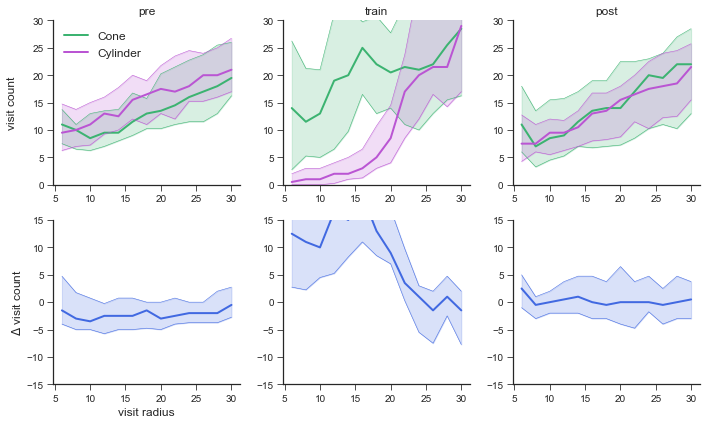

In [101]:
visitDiffFig, axs = plt.subplots(2,len(trialName), figsize=(10,6), gridspec_kw = {'width_ratios':[1, 1, 1]})

visitRadii = np.linspace(6,30,13)

for trial in range(len(trialName)):
    trialtype = trialName[trial]

    visCounts = np.nan*np.ones((numLM, numFlies, len(visitRadii)))   
    lineh = []
    
    for fly in range(numFlies):
        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        

        for ri, visRad in enumerate(visitRadii):
            entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,timeTrial,visRad)
            entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,timeTrial,visRad)
            
            visCounts[0, fly, ri] = np.nansum(entriesCone)
            visCounts[1, fly, ri] = np.nansum(entriesCyli)
            
    visitDiff = visCounts[0] - visCounts[1] # cone - cyli
    
    for i in range(numLM):
        line, = axs[0,trial].plot(visitRadii,np.nanmedian(visCounts[i], axis=0), color=objBoxColors[i][2], 
                                  linewidth=2, label=LMNames[i])
        percentiles = np.percentile(visCounts[i], [25,75], axis=0)
        axs[0,trial].plot(visitRadii,percentiles[0], color=objBoxColors[i][2], linewidth=0.5, label='')
        axs[0,trial].plot(visitRadii,percentiles[1], color=objBoxColors[i][2], linewidth=0.5, label='')
        axs[0,trial].fill_between(visitRadii,percentiles[0], percentiles[1], color=objBoxColors[i][2], alpha=0.2)
    axs[0,trial].set_ylim(0,30)
    axs[0,trial].set_title(trialName[trial], fontsize=12)
    myAxisTheme(axs[0,trial])
    
    axs[1,trial].plot(visitRadii,np.nanmedian(visitDiff, axis=0), color=BoxColors_pp[-1], linewidth=2)
    percentiles = np.percentile(visitDiff, [25,75], axis=0)
    axs[1,trial].plot(visitRadii,percentiles[0], color=BoxColors_pp[-1], linewidth=0.5)
    axs[1,trial].plot(visitRadii,percentiles[1], color=BoxColors_pp[-1], linewidth=0.5)
    axs[1,trial].fill_between(visitRadii,percentiles[0], percentiles[1], color=BoxColors_pp[-1], alpha=0.2)
    axs[1,trial].set_ylim(-15,15)
    myAxisTheme(axs[1,trial])

axs[0,0].set_ylabel('visit count\n', fontsize=12)
axs[1,0].set_xlabel('visit radius', fontsize=12)
axs[1,0].set_ylabel('$\Delta$ visit count', fontsize=12)

axs[0,0].legend(fontsize=12)

visitDiffFig.tight_layout()
visitDiffFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitsVsVisitRad_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

In [102]:
# set special limits for training trial
axs[0,1].set_ylim(0,40)
axs[1,1].set_ylim(-25,25)

visitDiffFig.tight_layout()
visitDiffFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitsVsVisitRad_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in minimum


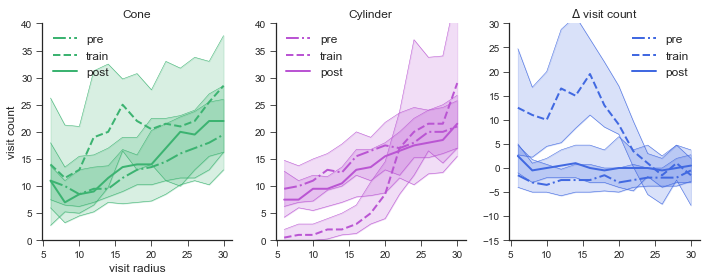

In [103]:
visitDiffFig, axs = plt.subplots(1,3, figsize=(10,4), gridspec_kw = {'width_ratios':[1, 1, 1]})

visitRadii = np.linspace(6,30,13)

ls = ['-.','--','-']

for trial in range(len(trialName)):
    trialtype = trialName[trial]

    visCounts = np.nan*np.ones((numLM, numFlies, len(visitRadii)))   
    lineh = []
    
    for fly in range(numFlies):
        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        
        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        for ri, visRad in enumerate(visitRadii):
            entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,timeTrial,visRad)
            entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,timeTrial,visRad)
            
            visCounts[0, fly, ri] = np.nansum(entriesCone)
            visCounts[1, fly, ri] = np.nansum(entriesCyli)
            
    visitDiff = visCounts[0] - visCounts[1] # cone - cyli
    
    for i in range(numLM):
        line, = axs[i].plot(visitRadii,np.nanmedian(visCounts[i], axis=0), color=objBoxColors[i][2], 
                                  linewidth=2, linestyle=ls[trial], label=trialtype)
        percentiles = np.percentile(visCounts[i], [25,75], axis=0)
        axs[i].plot(visitRadii,percentiles[0], color=objBoxColors[i][2], linewidth=0.5, label='')
        axs[i].plot(visitRadii,percentiles[1], color=objBoxColors[i][2], linewidth=0.5, label='')
        axs[i].fill_between(visitRadii,percentiles[0], percentiles[1], color=objBoxColors[i][2], alpha=0.2)
        axs[i].set_ylim(0,40)
        myAxisTheme(axs[i])
        axs[i].set_title(LMNames[i], fontsize=12)
    
    axs[2].plot(visitRadii,np.nanmedian(visitDiff, axis=0), color=BoxColors_pp[-1], linewidth=2,
               linestyle=ls[trial], label=trialtype)
    percentiles = np.percentile(visitDiff, [25,75], axis=0)
    axs[2].plot(visitRadii,percentiles[0], color=BoxColors_pp[-1], linewidth=0.5, label='')
    axs[2].plot(visitRadii,percentiles[1], color=BoxColors_pp[-1], linewidth=0.5, label='')
    axs[2].fill_between(visitRadii,percentiles[0], percentiles[1], color=BoxColors_pp[-1], alpha=0.2)
    axs[2].set_ylim(-15,30)
    myAxisTheme(axs[2])
    axs[2].set_title('$\Delta$ visit count', fontsize=12)

axs[0].set_ylabel('visit count', fontsize=12)
axs[0].set_xlabel('visit radius', fontsize=12)

for i in range(3):
    axs[i].legend(fontsize=12)

visitDiffFig.tight_layout()

visitDiffFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitsVsVisitRad_trials_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Visit sequences

### Visualisation of single-fly visits

Plot directory already exists


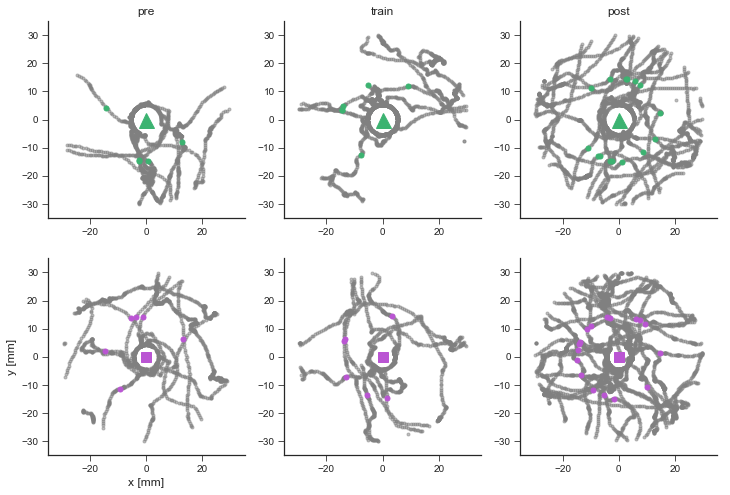

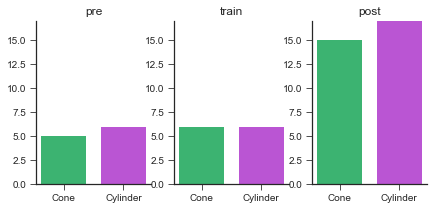

In [54]:
fly = 15

radLM = 30

movementFilter = 'moving > 0'

keyind_dLMs = (resdf_keylist.index('dist2cone'), resdf_keylist.index('dist2cyli'))
keyind_cLMs = (resdf_keylist.index('closestCone'), resdf_keylist.index('closestCyli'))

LMcoords = [coneCoords, cyliCoords]
LMshapes = ('^','s')
LMmsize = (15,10)

maxVisit = 0

zoomResFig, axs = plt.subplots(2,len(trialName), figsize=(12,8))
visitCountFig, axs2 = plt.subplots(1,len(trialName), figsize=(7,3))

for trial, cond in enumerate(trialName):
    
    LMvisitCount = []
    
    for LM in range(len(LMnames)):
        querystring = '(trialtype=="' + cond + '") & (flyID=="' + flyIDs[fly] + '")' #& (' + movementFilter + ')

        distLM = np.asarray(residency_df.query(querystring).iloc[:, keyind_dLMs[LM]:keyind_dLMs[LM] + 1]).squeeze()
        distLM[np.isnan(distLM)] = 100
        entries,exits,visitT,entryTime,exitTime = countvisits(distLM[distLM<=radLM],visitRad)
        LMvisitCount.append(sum(entries))
        maxVisit = max(maxVisit,sum(entries))
        
        closestLM = np.asarray(residency_df.query(querystring).iloc[:, keyind_cLMs[LM]:keyind_cLMs[LM] + 1]).squeeze()[distLM<=radLM]
        
        xLM = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos + 1]).squeeze()[distLM<=radLM]
        yLM = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos + 1]).squeeze()[distLM<=radLM]
        
        xLM[closestLM==0] = xLM[closestLM==0]-LMcoords[LM][0][0]
        yLM[closestLM==0] = yLM[closestLM==0]-LMcoords[LM][0][1]
        xLM[closestLM==1] = xLM[closestLM==1]-LMcoords[LM][1][0]
        yLM[closestLM==1] = yLM[closestLM==1]-LMcoords[LM][1][1]
        
        axs[LM,trial].plot(xLM, yLM, '.', color='grey', alpha=0.5)
        axs[LM,trial].plot(0, 0, marker=LMshapes[LM], markersize=LMmsize[LM], alpha=1, color=LMcols[LM])
        axs[LM,trial].plot(xLM[entries>0],yLM[entries>0],'o',color=LMcols[LM],markersize=5)
        
        axs[LM,trial].set_aspect('equal')
        axs[LM,trial].set_xlim(-(radLM+5),(radLM+5))
        axs[LM,trial].set_ylim(-(radLM+5),(radLM+5))
        myAxisTheme(axs[LM,trial])

    axs[0,trial].set_title(cond)
    
    axs2[trial].bar(range(len(LMnames)), LMvisitCount, color=LMcols, tick_label=LMnames, width=0.75)
    axs2[trial].set_title(cond)
    myAxisTheme(axs2[trial])

axs[1,0].set_xlabel('x [mm]', fontsize=12)
axs[1,0].set_ylabel('y [mm]', fontsize=12)

for trial in range(len(trialName)):
    axs2[trial].set_ylim(0, maxVisit)

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
zoomResFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitTrajectory_visitRad'+str(visitRad)+'mm_fly'+flyIDs[fly]+'.pdf', format='pdf')
visitCountFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCountDemo_visitRad'+str(visitRad)+'mm_fly'+flyIDs[fly]+'.pdf', format='pdf')

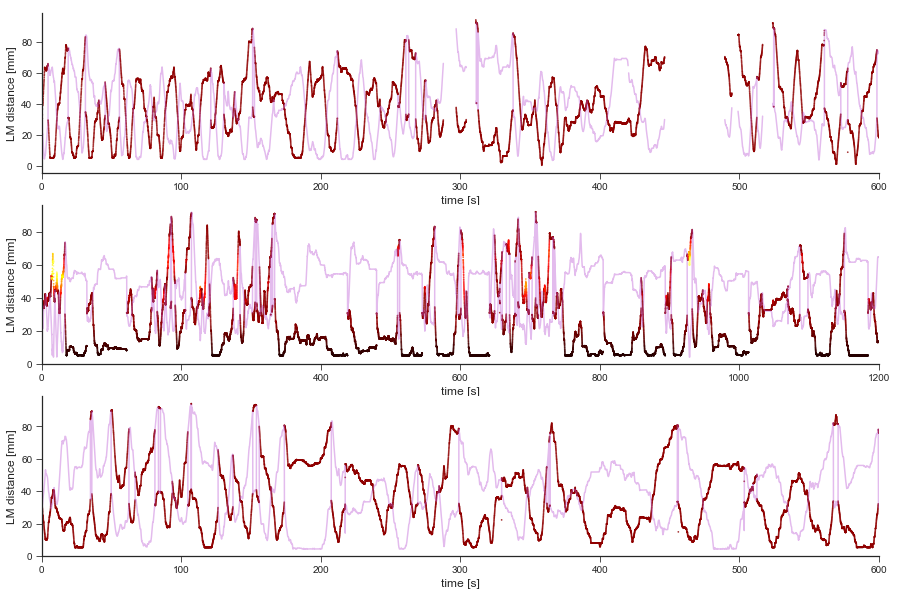

In [139]:
fly = 16

movementFilter = 'moving > 0'
histMax = (30,30)
histMin = (5,4) # adjust to LM base width
numBins = (25, 26)
varStyle = 'iqr' #'std', 'iqr'

LMnames = ['Cone', 'Cylinder']

keyind_dCone = resdf_keylist.index('dist2cone')
keyind_dCyli = resdf_keylist.index('dist2cyli')

numFlies = len(flyIDs)
numLM = len(LMnames)
# 0-LM1, 1-LM2

keyind_LMs = (keyind_dCone, keyind_dCyli)

radResFig = plt.figure(figsize=(15,10))

for trial, cond in enumerate(trialName):
    radResPlt = radResFig.add_subplot(len(trialName),1 , trial + 1)

    for LM in range(numLM):

        querystring = '(trialtype=="' + cond + '") & (flyID=="' + flyIDs[fly] + '")' #& (' + movementFilter + ')

        distLM = np.asarray(residency_df.query(querystring).iloc[:, keyind_LMs[LM]:keyind_LMs[LM] + 1]).squeeze()
        
        ev = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_EV:keyind_EV + 1]).squeeze()  
        time = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t + 1]).squeeze()     
        
        if LM==1:
            radResPlt.plot(time,distLM,color=LMcols[LM],alpha=0.4)
        else:
            radResPlt.scatter(time,distLM,s=3,c=ev,cmap='hot',edgecolors='none',alpha=0.8,vmin=0,vmax=50)#color=LMcols[LM])
            
        radResPlt.set_xlim(0,max(time))
        myAxisTheme(radResPlt)
        radResPlt.set_xlabel('time [s]', fontsize=12)
        if not LM:
            radResPlt.set_ylabel('LM distance [mm]', fontsize=12)